Algorithm implemented :   
Cluster based anomaly detection (K-mean)   
Repartition of data into categories then Gaussian/Elliptic Enveloppe on each categories separately   
Markov Chain    
Isolation Forest    
One class SVM     
RNN (comparison between prediction and reality)    
https://www.kaggle.com/victorambonati/unsupervised-anomaly-detection    

In [1]:
#%matplotlib notebook

import pandas as pd
import numpy as np

import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
#from pyemma import msm # not available on Kaggle Kernel
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

In [2]:
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        #distance.set_value(i, np.linalg.norm(Xa-Xb))
        distance.at[i] = np.linalg.norm(Xa-Xb)
    return distance

# train markov model to get transition matrix
def getTransitionMatrix (df):
    df = np.array(df)
    model = msm.estimate_markov_model(df, 1)
    return model.transition_matrix

def markovAnomaly(df, windows_size, threshold):
    transition_matrix = getTransitionMatrix(df)
    real_threshold = threshold**windows_size
    df_anomaly = []
    for j in range(0, len(df)):
        if (j < windows_size):
            df_anomaly.append(0)
        else:
            sequence = df[j-windows_size:j]
            sequence = sequence.reset_index(drop=True)
            df_anomaly.append(anomalyElement(sequence, real_threshold, transition_matrix))
    return df_anomaly

In [3]:
#df = pd.read_csv('../csv_data/m_data_fromNow.csv', usecols=['date', 'time', 'cpu'])
#df.head()

In [4]:
#df['timestamp'] = df[df.columns[0:2]]. apply(
#    lambda x: ' '.join(x.dropna().astype(str)),
#    axis=1)
#df.head()

In [5]:
## CSV : convert=> UTC -> [DATE time] cpu_value->[cpu]
df = pd.read_csv('../cto_k8s/m_data_10.11.1.80:9091.csv', usecols=['time', 'cpu_value'])
df.rename(columns={'cpu_value':'cpu'}, inplace=True)

df['timestamp'] = pd.to_datetime(df.time, unit='s')
df['cpu'] = df['cpu'].fillna(df['cpu'].mean())

In [6]:
df = df[['timestamp', 'cpu']]
df.head()

,timestamp,cpu
0,2020-08-04 00:00:00,0.565333
1,2020-08-04 00:10:00,0.571564
2,2020-08-04 00:20:00,0.543800
3,2020-08-04 00:30:00,0.534930
4,2020-08-04 00:40:00,0.569663


In [7]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5484 entries, 0 to 5483
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  5484 non-null   datetime64[ns]
 1   cpu        5484 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 85.8 KB
None


In [8]:
print(df['timestamp'].head())

0   2020-08-04 00:00:00
1   2020-08-04 00:10:00
2   2020-08-04 00:20:00
3   2020-08-04 00:30:00
4   2020-08-04 00:40:00
Name: timestamp, dtype: datetime64[ns]


In [9]:
print(df['cpu'].mean())

1.6809433177899136


<AxesSubplot:xlabel='timestamp'>

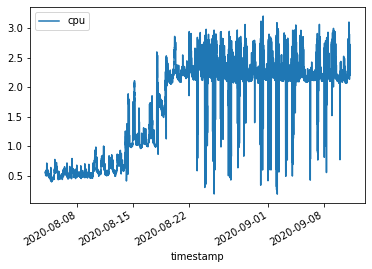

In [10]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.plot(x = 'timestamp', y='cpu')

In [11]:
df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours'] >= 8) & (df['hours'] <= 19)).astype(int)
df.head(40)

,timestamp,cpu,hours,daylight
0,2020-08-04 00:00:00,0.565333,0,0
1,2020-08-04 00:10:00,0.571564,0,0
2,2020-08-04 00:20:00,0.543800,0,0
3,2020-08-04 00:30:00,0.534930,0,0
4,2020-08-04 00:40:00,0.569663,0,0
5,2020-08-04 00:50:00,0.503467,0,0
6,2020-08-04 01:00:00,0.579867,1,0
7,2020-08-04 01:10:00,0.574533,1,0
8,2020-08-04 01:20:00,0.575000,1,0
9,2020-08-04 01:30:00,0.569973,1,0


In [12]:
s = pd.date_range('2020-08-04', '2020-08-31').to_series()
s.dt.dayofweek

2020-08-04    1
2020-08-05    2
2020-08-06    3
2020-08-07    4
2020-08-08    5
2020-08-09    6
2020-08-10    0
2020-08-11    1
2020-08-12    2
2020-08-13    3
2020-08-14    4
2020-08-15    5
2020-08-16    6
2020-08-17    0
2020-08-18    1
2020-08-19    2
2020-08-20    3
2020-08-21    4
2020-08-22    5
2020-08-23    6
2020-08-24    0
2020-08-25    1
2020-08-26    2
2020-08-27    3
2020-08-28    4
2020-08-29    5
2020-08-30    6
2020-08-31    0
Freq: D, dtype: int64

In [13]:
df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)
outliers_fraction = 0.01


In [14]:
df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

In [15]:
df['categories'] = df['WeekDay']*2 + df['daylight']


a = df.loc[df['categories'] == 0, 'cpu']
b = df.loc[df['categories'] == 1, 'cpu']
c = df.loc[df['categories'] == 2, 'cpu']
d = df.loc[df['categories'] == 3, 'cpu']


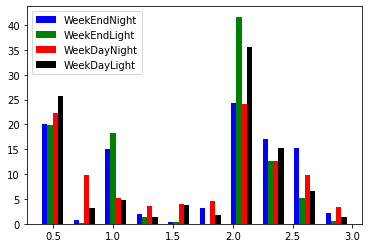

In [16]:
fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)

width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='WeekEndNight')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='WeekEndLight')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='WeekDayNight')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='WeekDayLight')

plt.rcParams['figure.figsize'] = [10, 5]
plt.legend()


In [17]:
# Take useful feature and standardize them
data = df[['cpu', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# reduce to 2 importants features
pca = PCA(n_components=2)
data = pca.fit_transform(data)
# standardize these 2 new features
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

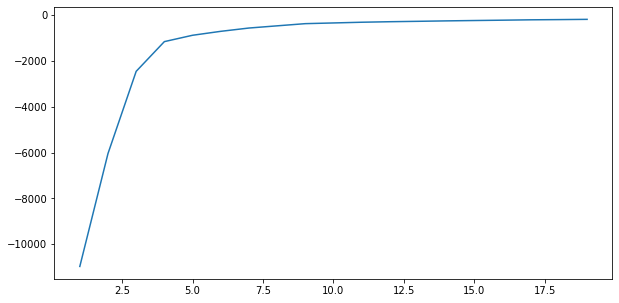

In [18]:
# calculate with different number of centroids to see the loss plot (elbow method)
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)

In [19]:
# Not clear for me, I choose 15 centroids arbitrarily and add these data to the central dataframe
df['cluster'] = kmeans[14].predict(data)
df['principal_feature1'] = data[0]
df['principal_feature2'] = data[1]
df['cluster'].value_counts()

10    494
8     491
3     480
7     426
11    405
2     400
4     378
0     336
14    333
9     317
6     310
13    302
5     289
12    271
1     252
Name: cluster, dtype: int64

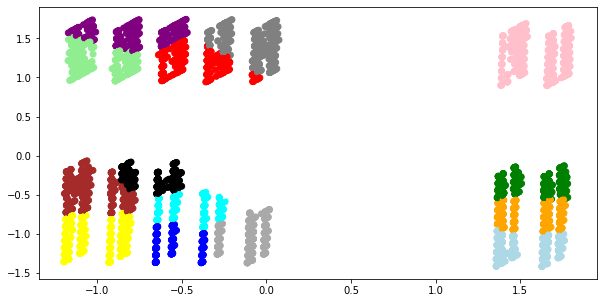

In [20]:
#plot the different clusters with the 2 main features
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey', 12:'lightblue', 13:'lightgreen', 14: 'darkgrey'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["cluster"].apply(lambda x: colors[x]))
plt.show()

In [21]:
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(data, kmeans[14])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly21 contain the anomaly result of method 2.1 Cluster (0:normal, 1:anomaly) 
df['anomaly21'] = (distance >= threshold).astype(int)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


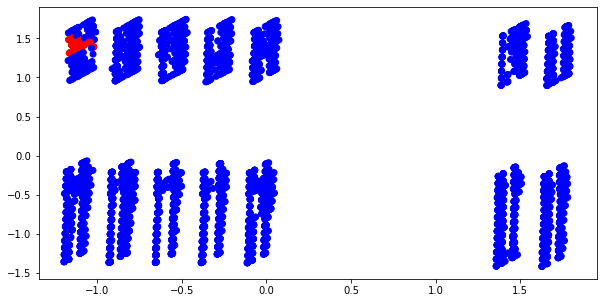

In [22]:
fig, ax = plt.subplots()
color = {0:'blue', 1:'red'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["anomaly21"].apply(lambda x: color[x]))
plt.show()

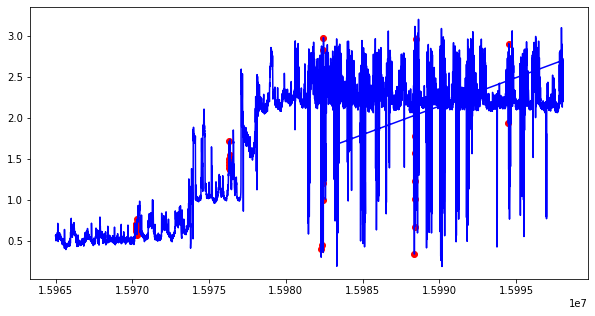

In [23]:
fig, ax = plt.subplots()
a = df.loc[df['anomaly21'] == 1, ['time_epoch', 'cpu']] #anomaly

ax.plot(df['time_epoch'], df['cpu'], color = 'blue')
ax.scatter(a['time_epoch'], a['cpu'], color = 'red')
plt.show()

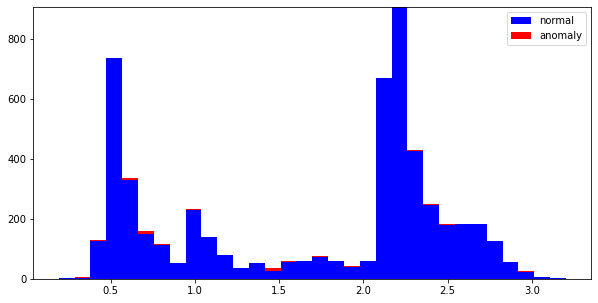

In [24]:
a = df.loc[df['anomaly21'] == 0, 'cpu']
b = df.loc[df['anomaly21'] == 1, 'cpu']

fig, axs = plt.subplots()
axs.hist([a, b], bins=32, stacked=True, color=['blue', 'red'], label = ['normal', 'anomaly'])
plt.legend()
plt.show()

## Categories + Gaussian

In [25]:
# creation of 4 differents data set based on categories defined before
df_class0 = df.loc[df['categories'] == 0, 'cpu']
df_class1 = df.loc[df['categories'] == 1, 'cpu']
df_class2 = df.loc[df['categories'] == 2, 'cpu']
df_class3 = df.loc[df['categories'] == 3, 'cpu']

<AxesSubplot:>

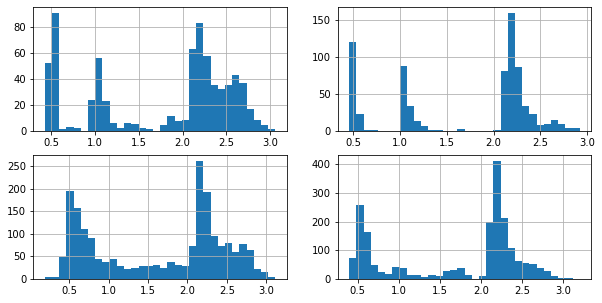

In [26]:
# plot the temperature repartition by categories
fig, axs = plt.subplots(2,2)
df_class0.hist(ax=axs[0,0],bins=32)
df_class1.hist(ax=axs[0,1],bins=32)
df_class2.hist(ax=axs[1,0],bins=32)
df_class3.hist(ax=axs[1,1],bins=32)

In [27]:
envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class0.values.reshape(-1,1)
envelope.fit(X_train)
df_class0 = pd.DataFrame(df_class0)
df_class0['deviation'] = envelope.decision_function(X_train)
df_class0['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class1.values.reshape(-1,1)
envelope.fit(X_train)
df_class1 = pd.DataFrame(df_class1)
df_class1['deviation'] = envelope.decision_function(X_train)
df_class1['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class2.values.reshape(-1,1)
envelope.fit(X_train)
df_class2 = pd.DataFrame(df_class2)
df_class2['deviation'] = envelope.decision_function(X_train)
df_class2['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class3.values.reshape(-1,1)
envelope.fit(X_train)
df_class3 = pd.DataFrame(df_class3)
df_class3['deviation'] = envelope.decision_function(X_train)
df_class3['anomaly'] = envelope.predict(X_train)

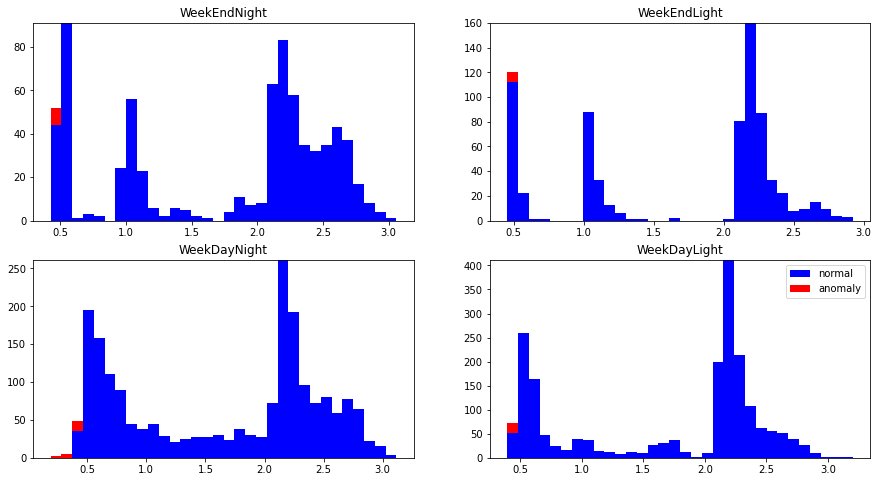

In [28]:
# plot the temperature repartition by categories with anomalies
a0 = df_class0.loc[df_class0['anomaly'] == 1, 'cpu']
b0 = df_class0.loc[df_class0['anomaly'] == -1, 'cpu']

a1 = df_class1.loc[df_class1['anomaly'] == 1, 'cpu']
b1 = df_class1.loc[df_class1['anomaly'] == -1, 'cpu']

a2 = df_class2.loc[df_class2['anomaly'] == 1, 'cpu']
b2 = df_class2.loc[df_class2['anomaly'] == -1, 'cpu']

a3 = df_class3.loc[df_class3['anomaly'] == 1, 'cpu']
b3 = df_class3.loc[df_class3['anomaly'] == -1, 'cpu']

plt.rcParams['figure.figsize'] = [15, 8]
fig, axs = plt.subplots(2,2)
axs[0,0].hist([a0,b0], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[0,1].hist([a1,b1], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[1,0].hist([a2,b2], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[1,1].hist([a3,b3], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[0,0].set_title("WeekEndNight")
axs[0,1].set_title("WeekEndLight")
axs[1,0].set_title("WeekDayNight")
axs[1,1].set_title("WeekDayLight")
plt.legend()
plt.show()

In [29]:
df_class = pd.concat([df_class0, df_class1, df_class2, df_class3])
df['anomaly22'] = df_class['anomaly']
df['anomaly22'] = np.array(df['anomaly22'] == -1).astype(float)

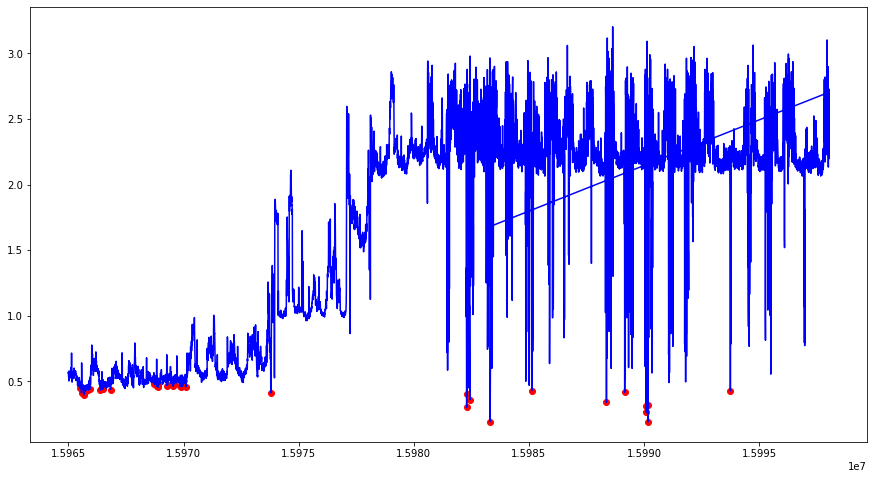

In [30]:
fig, ax = plt.subplots()

a = df.loc[df['anomaly22'] == 1, ('time_epoch', 'cpu')] #anomaly

ax.plot(df['time_epoch'], df['cpu'], color='blue')
ax.scatter(a['time_epoch'], a['cpu'], color='red')
plt.show()

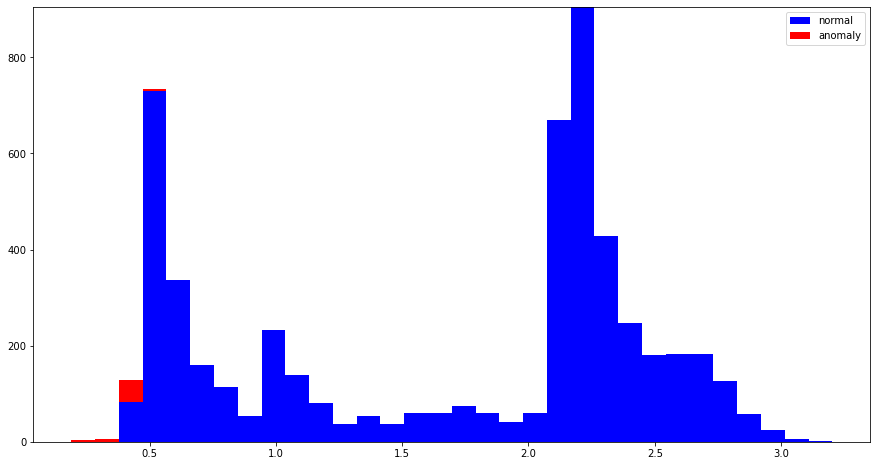

In [31]:
a = df.loc[df['anomaly22'] == 0, 'cpu']
b = df.loc[df['anomaly22'] == 1, 'cpu']

fig, axs = plt.subplots()
axs.hist([a, b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

## Markov chains

In [32]:
x1 = (df['cpu'] <= 18).astype(int)
x2 = ((df['cpu'] > 18) & (df['cpu'] <= 21)).astype(int)
x3 = ((df['cpu'] > 21) & (df['cpu'] <= 24)).astype(int)
x4 = ((df['cpu'] > 24) & (df['cpu'] <= 27)).astype(int)
x5 = (df['cpu'] > 27).astype(int)
df_mm = x1 + 2*x2 + 3*x3 + 4*x4 + 5*x5
print(df_mm)


0       1
1       1
2       1
3       1
4       1
       ..
5479    1
5480    1
5481    1
5482    1
5483    1
Name: cpu, Length: 5484, dtype: int64


## Isolation Forest

In [33]:
data = df[['cpu', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train isolation forest 
model =  IsolationForest(contamination = outliers_fraction)
model.fit(data)
# add the data to the main  
df['anomaly25'] = pd.Series(model.predict(data))
df['anomaly25'] = df['anomaly25'].map( {1: 0, -1: 1} )
print(df['anomaly25'].value_counts())

0    5429
1      55
Name: anomaly25, dtype: int64


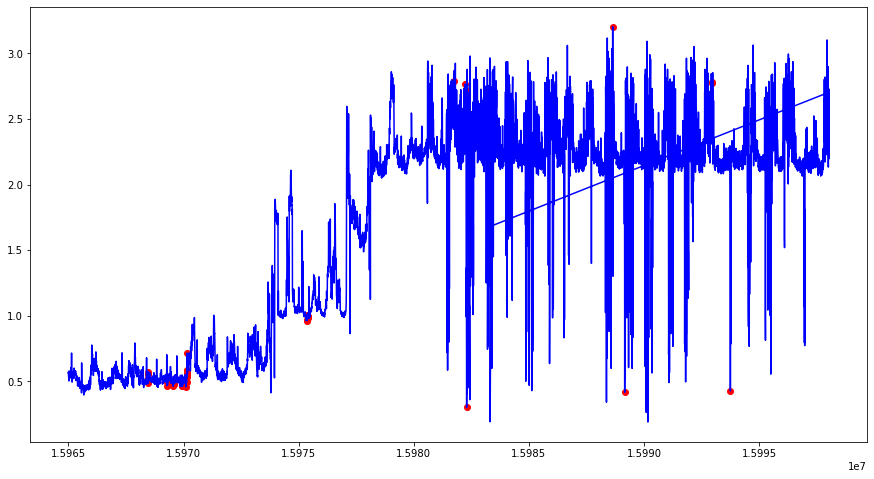

In [34]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly25'] == 1, ['time_epoch', 'cpu']] #anomaly

ax.plot(df['time_epoch'], df['cpu'], color='blue')
ax.scatter(a['time_epoch'],a['cpu'], color='red')
plt.show()

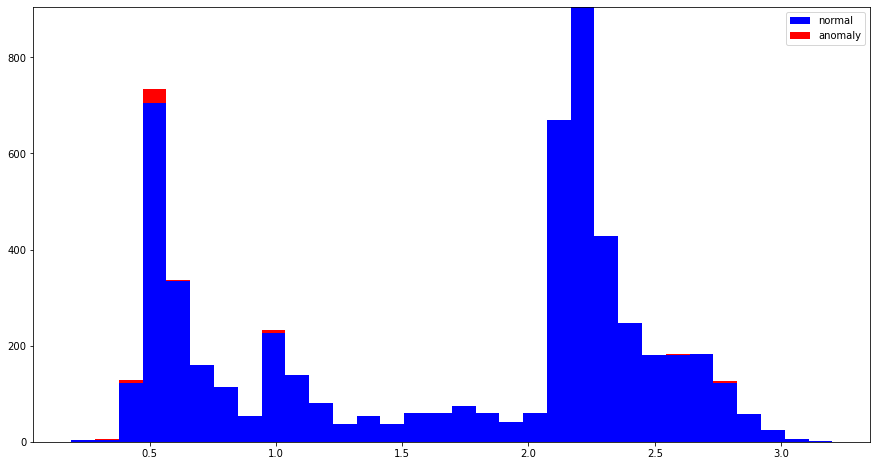

In [35]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly25'] == 0, 'cpu']
b = df.loc[df['anomaly25'] == 1, 'cpu']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label = ['normal', 'anomaly'])
plt.legend()
plt.show()

## One class SVM

In [36]:
# Take useful feature and standardize them 
data = df[['cpu', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
# train one class SVM 
model =  OneClassSVM(nu=0.95 * outliers_fraction) #nu=0.95 * outliers_fraction  + 0.05
data = pd.DataFrame(np_scaled)
model.fit(data)
# add the data to the main  
df['anomaly26'] = pd.Series(model.predict(data))
df['anomaly26'] = df['anomaly26'].map( {1: 0, -1: 1} )
print(df['anomaly26'].value_counts())

0    5434
1      50
Name: anomaly26, dtype: int64


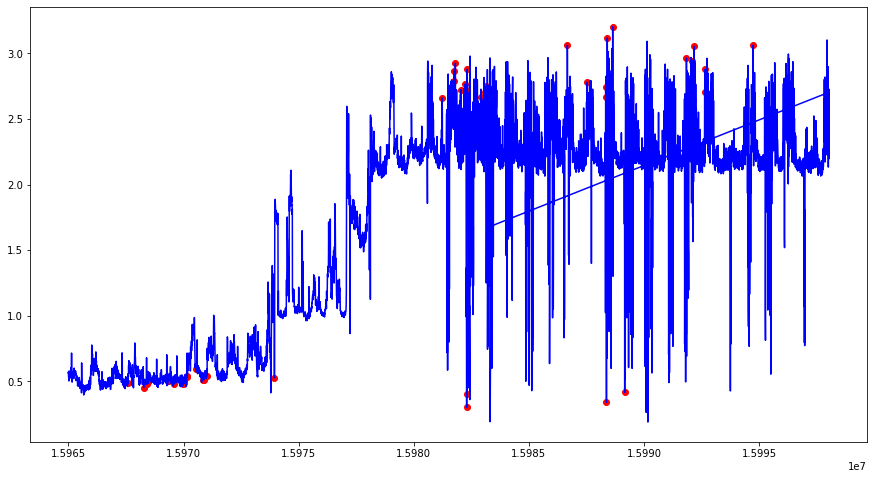

In [37]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly26'] == 1, ['time_epoch', 'cpu']] #anomaly

ax.plot(df['time_epoch'], df['cpu'], color='blue')
ax.scatter(a['time_epoch'],a['cpu'], color='red')
plt.show()

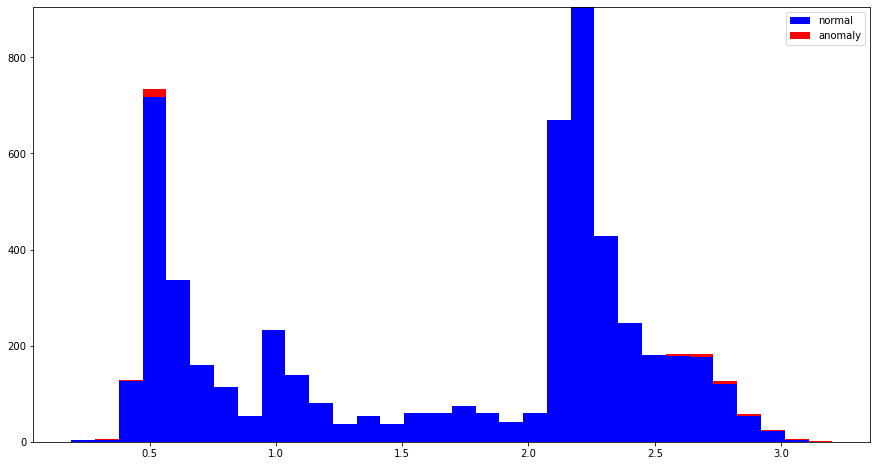

In [38]:
a = df.loc[df['anomaly26'] == 0, 'cpu']
b = df.loc[df['anomaly26'] == 1, 'cpu']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

# RNN

In [39]:
#select and standardize data
data_n = df[['cpu', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data_n)
data_n = pd.DataFrame(np_scaled)

# important parameters and train/test size
prediction_time = 1 
testdatasize = 1000
unroll_length = 50
testdatacut = testdatasize + unroll_length  + 1

#total_row = data_n.index.stop
#prediction_time = 1 
#testdatasize = int(total_row - (total_row * 0.95))
#unroll_length = int(total_row * 0.05)
#testdatacut = testdatasize + unroll_length + 1

x_train = data_n[0:-prediction_time-testdatacut].values
y_train = data_n[prediction_time:-testdatacut][0].values


# test data
x_test = data_n[0-testdatacut:-prediction_time].values
y_test = data_n[prediction_time-testdatacut:  ][0].values


In [40]:
def unroll(data,sequence_length=24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

# adapt the datasets for the sequence data shape
x_train = unroll(x_train,unroll_length)
x_test  = unroll(x_test,unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]

# see the shape
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (4382, 50, 5)
y_train (4382,)
x_test (1000, 50, 5)
y_test (1000,)


In [41]:
# specific libraries for RNN
# keras is a high layer build on Tensorflow layer to stay in high level/easy implementation
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time #helper libraries
from keras.models import model_from_json
import sys

In [42]:
### CJB : 파라미터 다시 확인 후 조절할 것

# Build the model
model = Sequential()
model.add(LSTM(100, input_shape = (50, 5), return_sequences = True)) 
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mean_squared_error', optimizer='rmsprop')
model.summary()
print('compilation time : {}'.format(time.time() - start))


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 100)           42400     
_________________________________________________________________
dropout (Dropout)            (None, 50, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 122,901
Trainable params: 122,901
Non-trainable params: 0
__________________________________________________

In [43]:
model.fit(x_train, y_train, batch_size=150, epochs=500, validation_split=0.1)

Epoch 1/500
27/27 [==============================] - 6s 213ms/step - loss: 0.2006 - val_loss: 0.4468
Epoch 2/500
27/27 [==============================] - 5s 187ms/step - loss: 0.1316 - val_loss: 0.4205
Epoch 3/500
27/27 [==============================] - 5s 176ms/step - loss: 0.1296 - val_loss: 0.4139
Epoch 4/500
27/27 [==============================] - 5s 181ms/step - loss: 0.1203 - val_loss: 0.4443
Epoch 5/500
27/27 [==============================] - 5s 179ms/step - loss: 0.1182 - val_loss: 0.4067
Epoch 6/500
27/27 [==============================] - 5s 173ms/step - loss: 0.1181 - val_loss: 0.3999
Epoch 7/500
27/27 [==============================] - 5s 169ms/step - loss: 0.1165 - val_loss: 0.3991
Epoch 8/500
27/27 [==============================] - 5s 175ms/step - loss: 0.1125 - val_loss: 0.4088
Epoch 9/500
27/27 [==============================] - 5s 174ms/step - loss: 0.1101 - val_loss: 0.3980
Epoch 10/500
27/27 [==============================] - 5s 176ms/step - loss: 0.1125 - val_lo

27/27 [==============================] - 5s 180ms/step - loss: 0.0663 - val_loss: 0.5000
Epoch 82/500
27/27 [==============================] - 5s 169ms/step - loss: 0.0691 - val_loss: 0.5350
Epoch 83/500
27/27 [==============================] - 5s 189ms/step - loss: 0.0640 - val_loss: 0.5445
Epoch 84/500
27/27 [==============================] - 5s 178ms/step - loss: 0.0623 - val_loss: 0.5914
Epoch 85/500
27/27 [==============================] - 5s 183ms/step - loss: 0.0632 - val_loss: 0.6186
Epoch 86/500
27/27 [==============================] - 5s 170ms/step - loss: 0.0590 - val_loss: 0.5647
Epoch 87/500
27/27 [==============================] - 5s 173ms/step - loss: 0.0603 - val_loss: 0.5560
Epoch 88/500
27/27 [==============================] - 5s 171ms/step - loss: 0.0600 - val_loss: 0.5874
Epoch 89/500
27/27 [==============================] - 5s 174ms/step - loss: 0.0614 - val_loss: 0.5821
Epoch 90/500
27/27 [==============================] - 5s 174ms/step - loss: 0.0611 - val_loss: 

Epoch 161/500
27/27 [==============================] - 4s 157ms/step - loss: 0.0384 - val_loss: 0.5614
Epoch 162/500
27/27 [==============================] - 4s 156ms/step - loss: 0.0377 - val_loss: 0.5548
Epoch 163/500
27/27 [==============================] - 4s 165ms/step - loss: 0.0356 - val_loss: 0.5821
Epoch 164/500
27/27 [==============================] - 4s 158ms/step - loss: 0.0383 - val_loss: 0.5668
Epoch 165/500
27/27 [==============================] - 4s 153ms/step - loss: 0.0388 - val_loss: 0.5849
Epoch 166/500
27/27 [==============================] - 4s 166ms/step - loss: 0.0350 - val_loss: 0.5568
Epoch 167/500
27/27 [==============================] - 4s 157ms/step - loss: 0.0365 - val_loss: 0.5363
Epoch 168/500
27/27 [==============================] - 4s 159ms/step - loss: 0.0371 - val_loss: 0.6127
Epoch 169/500
27/27 [==============================] - 4s 161ms/step - loss: 0.0365 - val_loss: 0.5790
Epoch 170/500
27/27 [==============================] - 5s 173ms/step - lo

27/27 [==============================] - 4s 154ms/step - loss: 0.0221 - val_loss: 0.5449
Epoch 241/500
27/27 [==============================] - 4s 159ms/step - loss: 0.0241 - val_loss: 0.5751
Epoch 242/500
27/27 [==============================] - 4s 162ms/step - loss: 0.0252 - val_loss: 0.5562
Epoch 243/500
27/27 [==============================] - 4s 160ms/step - loss: 0.0241 - val_loss: 0.5675
Epoch 244/500
27/27 [==============================] - 4s 158ms/step - loss: 0.0258 - val_loss: 0.6098
Epoch 245/500
27/27 [==============================] - 4s 161ms/step - loss: 0.0231 - val_loss: 0.5419
Epoch 246/500
27/27 [==============================] - 4s 154ms/step - loss: 0.0237 - val_loss: 0.5962
Epoch 247/500
27/27 [==============================] - 4s 160ms/step - loss: 0.0223 - val_loss: 0.5555
Epoch 248/500
27/27 [==============================] - 4s 159ms/step - loss: 0.0233 - val_loss: 0.5986
Epoch 249/500
27/27 [==============================] - 4s 159ms/step - loss: 0.0229 - v

27/27 [==============================] - 4s 156ms/step - loss: 0.0188 - val_loss: 0.5805
Epoch 320/500
27/27 [==============================] - 4s 162ms/step - loss: 0.0182 - val_loss: 0.5641
Epoch 321/500
27/27 [==============================] - 4s 160ms/step - loss: 0.0175 - val_loss: 0.5771
Epoch 322/500
27/27 [==============================] - 4s 157ms/step - loss: 0.0175 - val_loss: 0.5757
Epoch 323/500
27/27 [==============================] - 4s 163ms/step - loss: 0.0166 - val_loss: 0.5810
Epoch 324/500
27/27 [==============================] - 4s 159ms/step - loss: 0.0170 - val_loss: 0.5792
Epoch 325/500
27/27 [==============================] - 4s 160ms/step - loss: 0.0186 - val_loss: 0.5615
Epoch 326/500
27/27 [==============================] - 4s 158ms/step - loss: 0.0176 - val_loss: 0.5574
Epoch 327/500
27/27 [==============================] - 4s 159ms/step - loss: 0.0182 - val_loss: 0.5716
Epoch 328/500
27/27 [==============================] - 4s 160ms/step - loss: 0.0178 - v

27/27 [==============================] - 5s 170ms/step - loss: 0.0150 - val_loss: 0.5777
Epoch 399/500
27/27 [==============================] - 5s 172ms/step - loss: 0.0143 - val_loss: 0.5749
Epoch 400/500
27/27 [==============================] - 5s 173ms/step - loss: 0.0141 - val_loss: 0.5828
Epoch 401/500
27/27 [==============================] - 5s 176ms/step - loss: 0.0137 - val_loss: 0.5598
Epoch 402/500
27/27 [==============================] - 5s 202ms/step - loss: 0.0153 - val_loss: 0.5533
Epoch 403/500
27/27 [==============================] - 5s 184ms/step - loss: 0.0147 - val_loss: 0.5551
Epoch 404/500
27/27 [==============================] - 5s 177ms/step - loss: 0.0152 - val_loss: 0.5705
Epoch 405/500
27/27 [==============================] - 5s 172ms/step - loss: 0.0142 - val_loss: 0.5822
Epoch 406/500
27/27 [==============================] - 5s 169ms/step - loss: 0.0136 - val_loss: 0.5674
Epoch 407/500
27/27 [==============================] - 5s 170ms/step - loss: 0.0146 - v

27/27 [==============================] - 5s 167ms/step - loss: 0.0131 - val_loss: 0.5498
Epoch 478/500
27/27 [==============================] - 5s 175ms/step - loss: 0.0118 - val_loss: 0.5564
Epoch 479/500
27/27 [==============================] - 5s 184ms/step - loss: 0.0120 - val_loss: 0.5298
Epoch 480/500
27/27 [==============================] - 5s 180ms/step - loss: 0.0119 - val_loss: 0.5741
Epoch 481/500
27/27 [==============================] - 5s 174ms/step - loss: 0.0116 - val_loss: 0.5364
Epoch 482/500
27/27 [==============================] - 5s 194ms/step - loss: 0.0116 - val_loss: 0.5554
Epoch 483/500
27/27 [==============================] - 4s 158ms/step - loss: 0.0117 - val_loss: 0.5443
Epoch 484/500
27/27 [==============================] - 4s 158ms/step - loss: 0.0116 - val_loss: 0.5273
Epoch 485/500
27/27 [==============================] - 4s 161ms/step - loss: 0.0120 - val_loss: 0.5614
Epoch 486/500
27/27 [==============================] - 5s 173ms/step - loss: 0.0124 - v

In [44]:
loaded_model = model
diff=[]
ratio=[]
p = loaded_model.predict(x_test)
# predictions = lstm.predict_sequences_multiple(loaded_model, x_test, 50, 50)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))

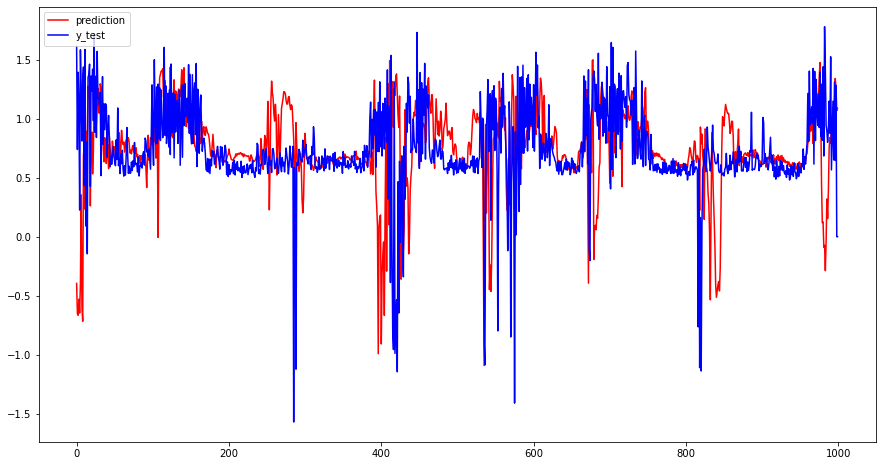

In [45]:
fig, axs = plt.subplots()
axs.plot(p,color='red', label='prediction')
axs.plot(y_test,color='blue', label='y_test')
plt.legend(loc='upper left')
plt.show()